In [1]:
import numpy as np
import networkx as nx
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import re
import seaborn as sns
import os
import igraph as ig
from bct import efficiency_wei
import matplotlib.pyplot as plt
from itertools import count
import cc3d

In [2]:
exclude = ['XYZres103',
           'XYZres104',
           'XYZres105',
           'XYZres105',
           'XYZres107',
           'XYZres133',
           'XYZres134',
           'XYZres135',
           'XYZres136',
           'XYZres137',
           'XYZres138',
           'XYZres139',
           'XYZres140',
           'XYZres183',
           'XYZres196',
           'XYZres197',
           'XYZres260',
           'XYZres288',
           'XYZres343',
           'XYZres340',
           'XYZres341',
           'XYZres250',
           'XYZres297',
           'XYZres295',
           'XYZres457',
           'XYZres455']

In [3]:
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)

In [4]:
dic = {}
for key in df.keys():
    if '3D' in key and ('vbm01' not in key and 'vbm02' not in key and 'SHAM7_3D' not in key and 'TBI45_3D' not in key and 'TBI11_3D' not in key and 'TBI65_3D' not in key and 'TBI22_3D' not in key and 'TBI28_3D' not in key and 'TBI40_3D' not in key and 'TBI51_3D' not in key and 'TBI70_3D' not in key):
        if 'vbm' not in key:
            addition = re.sub('C57','',re.sub('TBI','',re.sub('SHAM','',re.sub('_3D','',key))))
        else:
            addition = ''
        df[key] = df[key][~df[key][df[key].columns[1]].isin(exclude)]
        scans = np.array(df[key][df[key].columns[1]])
        scans = [x for x in scans if 'res' in str(x)]
        bottoms_1 = df[key][df[key][df[key].columns[3]] == 500]
        bottoms_2 = df[key][df[key][df[key].columns[2]] == 500]
        bottoms = pd.concat((bottoms_1,bottoms_2))
        bottoms = np.array(bottoms[bottoms.columns[1]])
        bottoms = [addition + '-' + x for x in bottoms]
        bottoms = [x for x in bottoms if 'res' in x]
        tops_1 = df[key][df[key][df[key].columns[3]] == 0]
        tops_2 = df[key][df[key][df[key].columns[2]] == 0]
        tops = pd.concat((tops_1,tops_2))
        tops = np.array(tops[tops.columns[1]])
        tops = [addition + '-' + x for x in tops]
        tops = [x for x in tops if 'res' in x]
        if len(tops) > 1:
            dic[tops[0]] = list(tops[1:])
        elif len(tops) == 1:
            dic[tops[0]] = tops
        if len(bottoms) > 1:
            dic[bottoms[0]] = list(bottoms[1:])
        elif len(bottoms) == 1:
            dic[bottoms[0]] = bottoms
dic_2 = {'45-XYZres290':['45-XYZres296'],
         '45-XYZres297':['45-XYZres295'],
         '45-XYZres294':['45-XYZres298'],
         '45-XYZres288':['45-XYZres300'],
         '11-XYZres95':['11-XYZres98','11-XYZres102'],
         '11-XYZres92':[],
         '11-XYZres93':['11-XYZres93','11-XYZres96','11-XYZres97','11-XYZres100','11-XYZres101'],
         '11-XYZres91':['11-XYZres94','11-XYZres99'],
         '22-XYZres164':['22-XYZres165','22-XYZres168','22-XYZres169'],
         '22-XYZres160':['22-XYZres161'],
         '22-XYZres163':['22-XYZres166','22-XYZres167','22-XYZres170'],
         '22-XYZres159':['22-XYZres162'],
         '28-XYZres184':['28-XYZres185'],
         '28-XYZres188':['28-XYZres189','28-XYZres193','28-XYZres194'],
         '28-XYZres186':['28-XYZres187','28-XYZres188','28-XYZres190','28-XYZres191','28-XYZres192','28-XYZres195'],
         '28-XYZres183':[],
         '40-XYZres248':['40-XYZres249'],
         '40-XYZres245':['40-XYZres252'],
         '40-XYZres244':[],
         '40-XYZres243':['40-XYZres246','40-XYZres247','40-XYZres251'],
         '51-XYZres297':['51-XYZres298','51-XYZres302','51-XYZres305','51-XYZres301'],
         '51-XYZres296':['51-XYZres306'],
         '51-XYZres299':['51-XYZres300','51-XYZres303','51-XYZres304'],
         '65-XYZres397':['65-XYZres398','65-XYZres401','65-XYZres402','65-XYZres405','65-XYZres408','65-XYZres409'],
         '65-XYZres396':['65-XYZres399','65-XYZres400'],
         '65-XYZres403':[],
         '70-XYZres420':['70-XYZres421','70-XYZres422'],
         '70-XYZres419':['70-XYZres416','70-XYZres413','70-XYZres410','70-XYZres412','70-XYZres416'],
         '70-XYZres414':['70-XYZres417'],
         '70-XYZres411':['70-XYZres418','70-XYZres415'],
         '-XYZres007':[]
        }
dic.update(dic_2) 
len(list(dic.keys()))

119

In [5]:
directory = Path('matt_preds_graphs_fwhm_single')
_files = directory.glob('*_warped_radii.pickle')
_files = sorted([x.as_posix() for x in _files])
_files2 = directory.glob('*_radii_forepaw.pickle')
_files2 = sorted([x.as_posix() for x in _files2])
_files += _files2
_files = sorted(_files)
print(len(_files))

directory = Path('matt_preds_graphs_fwhm_single_excel')
files = directory.glob('*_radii*amended_full.pickle')
files = sorted([x.as_posix() for x in files])
files = [x for x in files if any(y in x for y in list(dic.keys()))]
files = [x for x in files if '_0001' in x ]
files = sorted(files)
np.random.shuffle(files)
#files = [x for x in files if '20200217_17-XYZres116_0001' not in x]

print(len(files))

794
98


In [6]:
file

NameError: name 'file' is not defined

In [6]:
np.random.shuffle(files)
df = pd.DataFrame(columns=['scan', 'base_scan', 'sex', 'group', 'assortativity', 'wavelength', 'power', 'subject'])
df_eff = pd.DataFrame(columns=['scan', 'base_scan', 'sex', 'group', 'delta_efficiency', 'wavelength', 'power', 'subject'])
df_graph = pd.DataFrame(columns=['scan', 'base_scan', 'sex', 'group', 'subject', 'vessel_num', 'vessel_density', 'length_density', 'interior_vertex', 'interior_vertex_density', 'boundary vertex', 'vessel_length_mean', 'vessel_length_std'])
for file in tqdm(files):
    graph = nx.read_gpickle(file)
    if graph.edges[list(graph.edges)[0]]['treatment'] == 'SHAM':
        #print(file)
        _tmp_files = [file]
        key = [x for x in list(dic.keys()) if x in file][0]
        _tmp_files = _tmp_files + [re.sub(key,x,file) for x in dic[key]]
        _tmp_files = [x for x in _tmp_files if os.path.exists(x)]
        for _file in _tmp_files:
            _graph = nx.read_gpickle(_file)
            #print(_file)
            _line_graph = nx.line_graph(_graph)
            _res = []
            if len(graph.edges) == len(_graph.edges):# and _graph.edges[list(_graph.edges)[0]]['wavelength'] == 458:
                for edge in list(_graph.edges):
                    _line_graph.nodes[edge]['delta_radii'] = _graph.edges[edge]['delta_radii']
                    _res.append(_graph.edges[edge]['delta_radii'])
                    _line_graph.nodes[edge]['radii'] = _graph.edges[edge]['radii']
                    _graph.edges[edge]['restivity'] = 8 * 0.004 * (_graph.edges[edge]['weight']/10**6) / (np.pi * (_graph.edges[edge]['radii']/10**6)**4)
                if ~np.isnan(np.sum(_res)) and 'wavelength' in list(_graph.edges[edge].keys()):
                    assortativity = nx.numeric_assortativity_coefficient(_line_graph, 'delta_radii')
                    _tmp_row = {
                        'scan':_graph.edges[edge]['scan'],
                        'base_scan':key,
                        'sex':_graph.edges[edge]['gender'],
                        'group':graph.edges[list(graph.edges)[0]]['treatment'],
                        'assortativity':assortativity,
                        'wavelength':_graph.edges[edge]['wavelength'],
                        'power':_graph.edges[edge]['power'],
                        'subject':_graph.edges[edge]['subject']
                    }
                    df = df.append(_tmp_row,ignore_index=True)
                    if os.path.exists(re.sub('_0001','',_file)):
                        _graph_baseline = nx.read_gpickle(re.sub('_0001','',_file))
                        for edge in list(_graph.edges):
                            _graph_baseline.edges[edge]['restivity'] = 8 * 0.004 * (_graph_baseline.edges[edge]['weight']/10**6) / (np.pi * (_graph_baseline.edges[edge]['radii']/10**6)**4)
                        ###
                        for edge in list(_graph.edges): 
                            if graph.edges[edge]['mean_vessel_radii_baseline'] > 5:
                                _graph.remove_edge(edge[0],edge[1])
                                _graph_baseline.remove_edge(edge[0],edge[1])
                        ###
                        _graph_adj = nx.adjacency_matrix(_graph, weight = 'restivity').toarray()
                        _graph_base_adj = nx.adjacency_matrix(_graph_baseline, weight = 'restivity').toarray()
                        eff_base = efficiency_wei(_graph_base_adj)
                        eff = efficiency_wei(_graph_adj)
                        delta_efficiency = eff - eff_base
                        edge = list(_graph.edges)[0]
                        _tmp_row = {
                            'scan':_graph.edges[edge]['scan'],
                            'base_scan':key,
                            'sex':_graph.edges[edge]['gender'],
                            'group':_graph.edges[list(_graph.edges)[0]]['treatment'],
                            'delta_efficiency':delta_efficiency,
                            'efficiency_post':eff,
                            'efficiency_pre':eff_base,
                            'wavelength':_graph.edges[edge]['wavelength'],
                            'power':_graph.edges[edge]['power'],
                            'subject':_graph.edges[edge]['subject']
                        }
                        df_eff = df_eff.append(_tmp_row,ignore_index=True)
        #break
        #edge = list(graph.edges)[0]
        _tmp_row = {
            'scan':graph.edges[edge]['scan'],
            'base_scan':key,
            'sex':graph.edges[edge]['gender'],
            'group':graph.edges[list(graph.edges)[0]]['treatment'],
            'subject':graph.edges[edge]['subject'],
            'vessel_num': len(list(graph.edges)),
            'vessel_density': len(list(graph.edges))/ (0.2508*0.512*0.99*0.512*0.99),
            'length_density':(np.sum(list(nx.get_edge_attributes(graph,'weight').values())) * 10**-6) / (0.2508*0.512*0.99*0.512*0.99), 
            'interior_vertex': np.sum(np.array([d for n,d in graph.degree()]) > 1), 
            'interior_vertex_density': np.sum(np.array([d for n,d in graph.degree()]) > 1) / (0.2508*0.512*0.99*0.512*0.99),
            'boundary vertex': np.sum(np.array([d for n,d in graph.degree()]) == 1), 
            'vessel_length_mean':np.mean(list(nx.get_edge_attributes(graph,'weight').values())), 
            'vessel_length_std':np.std(list(nx.get_edge_attributes(graph,'weight').values()))
        }
        df_graph = df_graph.append(_tmp_row,ignore_index=True)
            #print(assortativity)

100%|██████████| 98/98 [11:03<00:00,  6.77s/it]


In [7]:
df = pd.DataFrame(columns=['scan', 'sex', 'group', 'volume density', 'volume density std', 'subject'])
for file in tqdm(files):
    graph = nx.read_gpickle(file)
    if graph.edges[list(graph.edges)[0]]['treatment'] == 'SHAM': #or graph.edges[list(graph.edges)[0]]['treatment'] == 'TBI'):
        #print(file)
        _tmp_files = [file]
        key = [x for x in list(dic.keys()) if x in file][0]
        _tmp_files = _tmp_files + [re.sub(key,x,file) for x in dic[key]]
        _tmp_files = [x for x in _tmp_files if os.path.exists(x)]
        _tmp_files = [re.sub('_0001','',x) for x in _tmp_files]
        res = []
        res_nrn = []
        for _file in _tmp_files:
            _graph = nx.read_gpickle(_file)
            _nrn = re.sub('matt_preds_graphs_fwhm_single_excel','matt_raw_warped_single_upsampled_seg',_file)
            _nrn = re.sub('_radii_amended_full.pickle','_seg_nrn.npy',_nrn)
            _nrn = re.sub('_radii_forepaw_amended_full.pickle','_seg_nrn.npy',_nrn)
            _nrn_seg = np.load(_nrn)
            if len(list(_graph.edges)) == len(list(graph.edges)):
                _tmp = 0
                thresh = 75
                image = _nrn_seg
                img_lab, N = cc3d.connected_components(image,return_N=True)
                unique, counts = np.unique(img_lab, return_counts=True)
                unique_keep = unique[counts>thresh]
                unique_keep = np.delete(unique_keep,[0])
                img_filt = np.zeros(img_lab.shape).astype('int8')
                img_filt[np.isin(img_lab,unique_keep)] = 1
                _img_lab, _N = cc3d.connected_components(img_filt,return_N=True)
                _unique, _counts = np.unique(_img_lab, return_counts=True)
                neuron_count = len(np.delete(np.unique(_unique),[0]))
                for edge in list(_graph.edges):
                    if ~np.isnan(np.pi * _graph.edges[edge]['radii']**2 * _graph.edges[edge]['weight']):
                        _tmp += np.pi * _graph.edges[edge]['radii']**2 * _graph.edges[edge]['weight']
                _tmp = _tmp/(1000**3)/(.507*.507*.250)
                res.append(_tmp)
                res_nrn.append(neuron_count)
        edge = list(graph.edges)[0]
        _tmp_row = {
            'scan':graph.edges[edge]['scan'],
            'sex':graph.edges[edge]['gender'],
            'group':graph.edges[list(graph.edges)[0]]['treatment'],
            'subject':graph.edges[edge]['subject'],
            'volume density': np.mean(res),
            'volume density std': np.std(res),
            'neuron count': np.mean(res_nrn),
            'neuron count std': np.std(res_nrn),
            'neuron density': np.mean(np.array(res_nrn)/(.507*.507*.250)),
            'neuron density std': np.std(np.array(res_nrn)/(.507*.507*.250))
        }
        df = df.append(_tmp_row,ignore_index=True)

100%|██████████| 98/98 [09:09<00:00,  5.61s/it]


In [ ]:
thresh = 75
image = _nrn_seg
img_lab, N = cc3d.connected_components(image,return_N=True)
unique, counts = np.unique(img_lab, return_counts=True)
unique_keep = unique[counts>thresh]
unique_keep = np.delete(unique_keep,[0])
img_filt = np.zeros(img_lab.shape).astype('int8')
img_filt[np.isin(img_lab,unique_keep)] = 1
_img_lab, _N = cc3d.connected_components(img_filt,return_N=True)
_unique, _counts = np.unique(_img_lab, return_counts=True)
neuron_count = len(np.delete(np.unique(_unique),[0]))

In [9]:
df_eff

,scan,base_scan,sex,group,delta_efficiency,wavelength,power,subject,efficiency_post,efficiency_pre
0,XYZres217,35-XYZres213,female,SHAM,1.251986e+16,458,20,SHAM35_3D,1.835762e+16,5.837755e+15
1,XYZres214,35-XYZres213,female,SHAM,-4.313024e+14,458,20,SHAM35_3D,2.436625e+15,2.867927e+15
2,XYZres153,23-XYZres158,male,SHAM,5.349844e+15,458,20,SHAM23_3D,6.301626e+15,9.517825e+14
3,XYZres203,32-XYZres199,male,SHAM,-2.500488e+13,458,20,SHAM32_3D,7.643026e+15,7.668031e+15
4,XYZres200,32-XYZres199,male,SHAM,-4.919066e+14,458,5,SHAM32_3D,5.380719e+15,5.872625e+15
...,...,...,...,...,...,...,...,...,...,...
69,XYZres456,76-XYZres459,male,SHAM,-9.845361e+13,458,5,SHAM76_3D,2.753293e+15,2.851747e+15
70,XYZres462,76-XYZres459,male,SHAM,1.441386e+14,552,9,SHAM76_3D,3.249527e+15,3.105388e+15
71,XYZres329,53-XYZres332,male,SHAM,1.772763e+16,458,5,SHAM53_3D,2.127627e+16,3.548640e+15
72,XYZres333,53-XYZres332,male,SHAM,1.948624e+16,458,20,SHAM53_3D,2.387071e+16,4.384478e+15


In [8]:
df.to_excel('assortativity.xlsx')
df_eff.to_excel('efficiency.xlsx')

In [ ]:
_ = np.array(df['volume density'])
print(np.mean(_[~np.isnan(_)]))
print(np.std(_[~np.isnan(_)]))

In [9]:
_ = np.array(df['neuron count'])
print(np.mean(_[~np.isnan(_)]))
print(np.std(_[~np.isnan(_)]))

313.1046875
202.11744919219097


In [10]:
_ = np.array(df['neuron density'])
print(np.mean(_[~np.isnan(_)]))
print(np.std(_[~np.isnan(_)]))

4872.295749059517
3145.197206636726


In [ ]:
res

In [ ]:
Gcc = sorted(nx.connected_components(_graph_baseline), key=len, reverse=True)
G0 = _graph_baseline.subgraph(Gcc[0])

#colors = np.array(list(nx.get_node_attributes(G0,'delta_radii').values()))
#colors[colors>1] = 1
#colors[colors<-1] = -1

#mapping = dict(zip(sorted(groups),count()))
nodes = G0.nodes()
#colors = [mapping[G0.nodes[n]['delta_radii']] for n in nodes]

pos = nx.spring_layout(G0, k=2/np.sqrt(len(G0.nodes)))
ec = nx.draw_networkx_edges(G0, pos, alpha=0.7)
nc = nx.draw_networkx_nodes(G0, pos, node_size=30, nodelist=nodes)
#cbar = plt.colorbar(nc)
#cbar.set_label(r'$\Delta$ Radius ($\mu$m)', rotation=270,size=14, labelpad=20)
plt.title('{:,.3f}'.format(eff/1e15) + r' $P\Omega^{-1}$')
plt.axis('off')
plt.tight_layout()
plt.savefig('graph_efficiency_4.jpeg')
plt.show()

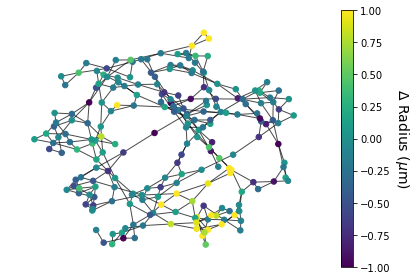

In [24]:
Gcc = sorted(nx.connected_components(_line_graph), key=len, reverse=True)
G0 = _line_graph.subgraph(Gcc[0])

colors = np.array(list(nx.get_node_attributes(G0,'delta_radii').values()))
colors[colors>1] = 1
colors[colors<-1] = -1

#mapping = dict(zip(sorted(groups),count()))
nodes = G0.nodes()
#colors = [mapping[G0.nodes[n]['delta_radii']] for n in nodes]

pos = nx.spring_layout(G0, k=2/np.sqrt(len(G0.nodes)))
ec = nx.draw_networkx_edges(G0, pos, alpha=0.7)
nc = nx.draw_networkx_nodes(G0, pos, node_size=30, nodelist=nodes, node_color=colors, cmap=plt.cm.viridis)
cbar = plt.colorbar(nc)
cbar.set_label(r'$\Delta$ Radius ($\mu$m)', rotation=270,size=14, labelpad=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('graph_assortativity.png')
plt.show()

In [33]:
_graph[0][10]['power']

20

In [ ]:
_line_graph.nodes[edge]['delta_radii']

In [29]:
list(_graph.edges)

[(0, 10),
 (1, 5),
 (2, 8),
 (3, 113),
 (4, 8),
 (5, 12),
 (5, 7),
 (7, 23),
 (7, 20),
 (8, 18),
 (9, 15),
 (11, 21),
 (13, 14),
 (14, 21),
 (14, 15),
 (15, 36),
 (16, 22),
 (16, 49),
 (16, 156),
 (17, 32),
 (19, 26),
 (21, 45),
 (22, 57),
 (22, 26),
 (24, 26),
 (25, 27),
 (25, 37),
 (27, 29),
 (27, 35),
 (27, 34),
 (28, 30),
 (28, 61),
 (28, 39),
 (29, 41),
 (29, 42),
 (30, 38),
 (31, 71),
 (32, 33),
 (32, 59),
 (33, 35),
 (33, 34),
 (34, 36),
 (35, 41),
 (36, 64),
 (37, 42),
 (38, 39),
 (39, 61),
 (40, 82),
 (41, 42),
 (43, 98),
 (44, 50),
 (46, 122),
 (46, 70),
 (46, 47),
 (47, 69),
 (47, 65),
 (48, 77),
 (49, 50),
 (49, 52),
 (50, 56),
 (51, 131),
 (52, 63),
 (52, 56),
 (53, 66),
 (54, 83),
 (55, 71),
 (56, 62),
 (58, 91),
 (59, 79),
 (60, 84),
 (61, 76),
 (62, 80),
 (62, 63),
 (63, 81),
 (64, 66),
 (64, 89),
 (66, 88),
 (67, 87),
 (68, 87),
 (68, 143),
 (68, 103),
 (69, 70),
 (69, 105),
 (70, 80),
 (71, 78),
 (72, 141),
 (73, 96),
 (74, 86),
 (75, 94),
 (76, 85),
 (76, 90),
 (78, 

In [56]:
df = nx.to_pandas_edgelist(nx.read_gpickle(files[0]))
for file in tqdm(files[1:]):
    _df = nx.to_pandas_edgelist(nx.read_gpickle(file))
    if _df.iloc[0]['treatment'] == 'SHAM':
        df = df.append(_df,ignore_index=True)
    
    

100%|██████████| 97/97 [00:05<00:00, 19.27it/s]


In [57]:
len(df)

12133

In [58]:
print(np.mean(df['mean_vessel_radii_baseline']))
print(np.std(df['mean_vessel_radii_baseline']))

2.1576540065735967
1.6111944881253393


In [59]:
print(df.mean())

source                        2.303187e+02
target                        2.512315e+02
age                           2.888415e+02
wavelength                    4.606582e+02
mean_vessel_radii_baseline    2.157654e+00
delta_radii                   3.105532e-01
timepoint                     1.000000e+00
end-0y                        2.610579e+02
end-1x                        1.127716e+02
euclidean-dst                 4.821623e+01
end-1z                        2.696486e+02
neuron_distance_std                    inf
end-0x                        1.121324e+02
power                         9.711211e+00
radii                         2.214321e+00
mean_depth                    1.123524e+02
mean_neuron_distance          3.131437e+01
start_depth                   2.579260e+02
imaging_weight                2.846139e+01
std_vessel_radii_baseline     7.769706e-01
num_vessel_radii_baseline     4.940658e+00
neuron_distance_min           2.267977e+01
days_post_injury              1.726333e+01
end-0z     

/tmp/ipykernel_1756835/2807316344.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df.mean())


In [61]:
print(df.std())

source                         166.763017
target                         169.651274
age                             66.656988
wavelength                      15.582725
mean_vessel_radii_baseline       1.611261
delta_radii                      0.302883
timepoint                        0.000000
end-0y                         142.713310
end-1x                          64.784054
euclidean-dst                   35.080354
end-1z                         142.379552
neuron_distance_std                   NaN
end-0x                          64.600385
power                            6.909515
radii                            1.927166
mean_depth                      61.540394
mean_neuron_distance            19.798410
start_depth                     43.239660
imaging_weight                   6.187644
std_vessel_radii_baseline        0.989406
num_vessel_radii_baseline        1.663580
neuron_distance_min             20.303633
days_post_injury                 4.293698
end-0z                         142

/tmp/ipykernel_1756835/2597523637.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df.std())


In [25]:
df['source2']=df['source'].astype('string') + df['scan'] + df['subject']
df['target2']=df['target'].astype('string') + df['scan'] + df['subject']

In [26]:
junctions = np.unique(np.concatenate((df['source2'].to_numpy(),df['target2'].to_numpy())), return_counts=True)

In [27]:
_junctions = junctions[0][junctions[1]>2]

In [28]:
len(_junctions)

6193

In [15]:
len(np.unique(df['source2'][df['source2'].isin(_junctions)]))

5888

In [16]:
res = []
for junc in _junctions:
    if junc in df['source2'].to_numpy():
        res.append(df[df['source2']==junc]['end-0x'].iloc[0])
    elif junc in df['target2'].to_numpy():
        res.append(df[df['target2']==junc]['end-1x'].iloc[0])
    else:
        print('error')
        break

In [17]:
#plt.hist(res)

In [29]:
df['mean_depth'][df['start_depth']==249.2] = df['mean_depth'][df['start_depth']==249.2] + 249.2
df['mean_depth'][df['start_depth']==250.8] = 250.8 - df['mean_depth'][df['start_depth']==250.8] 
df['mean_depth'][df['start_depth']==500] = 500 - df['mean_depth'][df['start_depth']==500] 

/tmp/ipykernel_1756835/1945298023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_depth'][df['start_depth']==249.2] = df['mean_depth'][df['start_depth']==249.2] + 249.2
/tmp/ipykernel_1756835/1945298023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_depth'][df['start_depth']==250.8] = 250.8 - df['mean_depth'][df['start_depth']==250.8]
/tmp/ipykernel_1756835/1945298023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [19]:
df['end-0x'][df['start_depth']==249.2] = df['end-0x'][df['start_depth']==249.2] + 249.2
df['end-0x'][df['start_depth']==250.8] = 250.8 - df['end-0x'][df['start_depth']==250.8] 
df['end-0x'][df['start_depth']==500] = 500 - df['end-0x'][df['start_depth']==500] 
df['end-1x'][df['start_depth']==249.2] = df['end-1x'][df['start_depth']==249.2] + 249.2
df['end-1x'][df['start_depth']==250.8] = 250.8 - df['end-1x'][df['start_depth']==250.8] 
df['end-1x'][df['start_depth']==500] = 500 - df['end-1x'][df['start_depth']==500] 

/tmp/ipykernel_1756835/836843878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end-0x'][df['start_depth']==249.2] = df['end-0x'][df['start_depth']==249.2] + 249.2
/tmp/ipykernel_1756835/836843878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end-0x'][df['start_depth']==250.8] = 250.8 - df['end-0x'][df['start_depth']==250.8]
/tmp/ipykernel_1756835/836843878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end-

(array([ 879., 1517., 1780., 1982., 1233., 1156., 1418., 1062.,  773.,
         333.]),
 array([  2.68043478,  52.48953416, 102.29863354, 152.10773292,
        201.9168323 , 251.72593168, 301.53503106, 351.34413043,
        401.15322981, 450.96232919, 500.77142857]),
 <BarContainer object of 10 artists>)

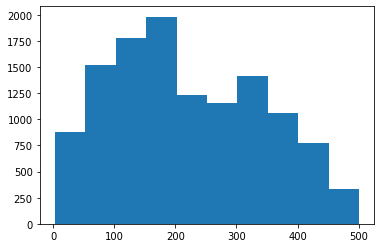

In [30]:
plt.hist(df['mean_depth'])

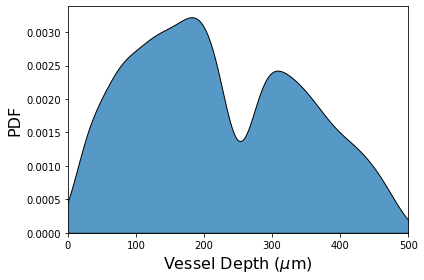

In [31]:
sns.kdeplot(data=df,x='mean_depth', multiple="stack")
plt.xlabel(r'Vessel Depth ($\mu$m)',fontsize=16)
plt.ylabel('PDF',fontsize=16)
plt.xlim(0,500)
plt.tight_layout()
plt.savefig('vessel_depth.png')

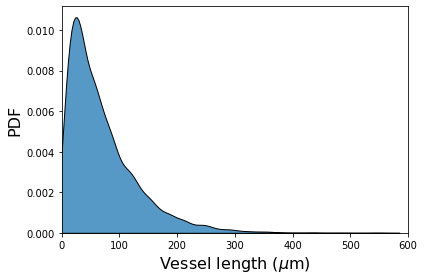

In [32]:
sns.kdeplot(data=df,x='weight', multiple="stack")
plt.xlabel(r'Vessel length ($\mu$m)',fontsize=16)
plt.ylabel('PDF',fontsize=16)
plt.xlim(0,600)
plt.tight_layout()
plt.savefig('vessel_length.png')

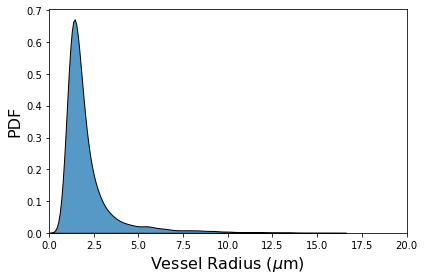

In [33]:
sns.kdeplot(data=df,x='mean_vessel_radii_baseline', multiple="stack")
plt.xlabel(r'Vessel Radius ($\mu$m)',fontsize=16)
plt.ylabel('PDF',fontsize=16)
plt.xlim(0,20)
plt.tight_layout()
plt.savefig('vessel_radius.png')

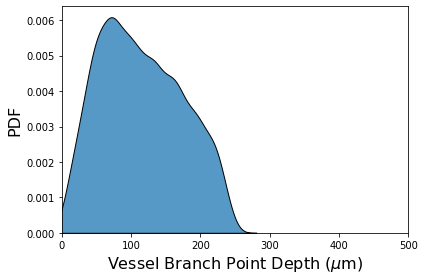

In [34]:
sns.kdeplot(x=res, multiple='stack')
plt.xlabel(r'Vessel Branch Point Depth ($\mu$m)',fontsize=16)
plt.ylabel('PDF',fontsize=16)
plt.xlim(0,500)
plt.tight_layout()
plt.savefig('branch_depth.png')

In [ ]:
df.keys()

In [ ]:
df_eff['delta_efficiency'] = df_eff['delta_efficiency']/10**15

In [ ]:
df_eff

In [ ]:
df

In [7]:
df.to_excel('assortativity.xlsx')
df_eff.to_excel('efficiency.xlsx')

In [ ]:
print(np.mean(df_graph['boundary vertex'] + df_graph['interior_vertex']))
print(np.std(df_graph['boundary vertex'] + df_graph['interior_vertex']))

In [ ]:
print(np.mean(df_graph['length_density']))
print(np.std(df_graph['length_density']))

In [ ]:
np.sqrt(np.sum(df_graph['vessel_length_std']**2))/len(df_graph['vessel_length_std'])

In [ ]:
print(np.std(df['weight']))

In [54]:
print(df_graph.mean())

vessel_num                  367.666667
vessel_density             5705.798289
length_density                0.400907
interior_vertex             207.151515
interior_vertex_density    3214.772694
boundary vertex             128.727273
vessel_length_mean           77.015047
vessel_length_std            62.226600
dtype: float64


/tmp/ipykernel_1756835/493269666.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df_graph.mean())


In [55]:
print(df_graph.std())

vessel_num                  238.756239
vessel_density             3705.244624
length_density                0.216208
interior_vertex             153.713435
interior_vertex_density    2385.470138
boundary vertex              52.335619
vessel_length_mean           13.655980
vessel_length_std             9.244494
dtype: float64


/tmp/ipykernel_1756835/1986181701.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df_graph.std())


In [ ]:
np.std(df_graph['boundary vertex'])

In [ ]:
len(np.unique(df_graph['subject']))

In [ ]:
df_eff

In [ ]:
np.array([d for n,d in graph.degree()]) == 3

In [ ]:
!pip install ipgraph

In [ ]:
list(nx.get_edge_attributes(graph,'weight').values())

In [ ]:
_line_graph.nodes[edge]

In [ ]:
_line_graph.edges[list(_line_graph.edges)[0]]

In [ ]:
edge